In [3]:
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io

/Users/akhilbandi/anaconda3/envs/GLM_tensorflow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
# Load the .mat file

mat_data = scipy.io.loadmat('/Volumes/Runyan2/Akhil/VACANT_pilot_summer_2023/STHQ-3-3L/CBHQ-3-3L_231005_Cell.mat')

In [19]:
def structured_array_to_dict(arr):
    if not arr.dtype.names:
        return arr.tolist()
    
    return {name: structured_array_to_dict(arr[name]) for name in arr.dtype.names}

def convert_dataCell_to_dict(mat_data): # Convert 'dataCell' to a list of dictionaries
    dataCell_list = [structured_array_to_dict(mat_data['dataCell'][0, i][0, 0]) for i in range(mat_data['dataCell'].shape[1])]
    return dataCell_list

def get_perc_correct_all_conditions(dataCell_list):
    # Convert numpy array values to native Python types
    correct_values = [int(entry['result']['correct'][0][0][0]) for entry in dataCell_list]
    condition_values = [int(entry['maze']['condition'][0][0][0]) for entry in dataCell_list]

    # Re-compute the total counts and correct counts for each condition
    total_counts = {}
    correct_counts = {}

    for condition, correct in zip(condition_values, correct_values):
        if condition not in total_counts:
            total_counts[condition] = 0
            correct_counts[condition] = 0
        total_counts[condition] += 1
        correct_counts[condition] += correct

    # Compute the percentage of correct answers for each condition again
    percentage_correct = {condition: (correct_counts[condition] / total_counts[condition]) * 100 for condition in total_counts}

    # Sort conditions for better plotting
    sorted_conditions = sorted(percentage_correct.keys())
    sorted_percentages = [percentage_correct[condition] for condition in sorted_conditions]

    return correct_values, condition_values, total_counts, correct_counts, percentage_correct, sorted_conditions, sorted_percentages

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def determine_color(condition):
    if condition in [1, 4, 5, 8]:
        return "pink"
    elif condition in [2, 3, 6, 7]:
        return "orange"
    else:
        return "gray"  # Default color

def plot_perc_correct_all_conditions(sorted_conditions, sorted_percentages):
    fig, ax = plt.subplots(figsize=(5, 3))
    colors = ['red' if condition <= 4 else 'blue' for condition in sorted_conditions]

    # Plot using ax object
    bars = ax.bar(sorted_conditions, sorted_percentages, color=colors, alpha=0.7)
    ax.set_xlabel('Condition')
    ax.set_ylabel('% Correct')
    ax.set_title('Percentage of Correct Choices for Each Condition')
    ax.set_ylim(0, 100)  # Set y-axis limits to [0, 100] for percentage values
    ax.set_xticks(sorted_conditions)
    ax.legend(handles=[bars[0], bars[4]], labels=['V-relevant', 'A-relevant'])
    plt.tight_layout()
    plt.show()

def plot_performance(condition_values, correct_values):
    # Determine the colors for each trial based on its condition
    trial_colors = [determine_color(condition) for condition in condition_values]

    # Identify points where trials shift from either 1-4 to 5-8 or vice-versa
    shift_points = []
    for i in range(1, len(condition_values)):
        if (condition_values[i-1] <= 4 and condition_values[i] >= 5) or (condition_values[i-1] >= 5 and condition_values[i] <= 4):
            shift_points.append(i)

    window_size = 20
    smoothed_values = running_mean(correct_values, window_size)

    # Create the plots
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

    # Plot running mean on ax1

    # Plot segments of the running mean line based on condition color-coding
    start_idx = window_size - 1
    for i in range(start_idx, len(correct_values)):
        color = "red" if condition_values[i] <= 4 else "blue"
        ax1.plot([i-1, i], [smoothed_values[i-start_idx-1], smoothed_values[i-start_idx]], color=color, label='_nolegend_')
    legend_labels = ["V-rel", "A-rel"]
    legend_colors = ["red", "blue"]
    markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in legend_colors]
    ax1.legend(markers, legend_labels, numpoints=1)
    ax1.set_title("Running Mean of Correct Choices")
    for shift_point in shift_points:
        ax1.axvline(x=shift_point, color='black', linestyle='--', linewidth=1)
    ax1.set_xlim(0,400)
    ax1.set_ylim(0,1)

    # Scatter plot on ax2 for correct values with color-coding based on conditions

    # Add jitter to correct_values
    jitter_amount = 0.05
    jittered_correct_values = [value + np.random.uniform(-jitter_amount, jitter_amount) for value in correct_values]

    # Scatter plot on ax2 for jittered correct values with color-coding based on conditions
    scatter = ax2.scatter(range(len(jittered_correct_values)), jittered_correct_values, c=trial_colors, alpha=0.7, label='_nolegend_')
    for shift_point in shift_points:
        ax2.axvline(x=shift_point, color='black', linestyle='--', linewidth=1)

    # Adding legend for congruent and incongruent conditions
    legend_labels = ["Congruent", "Incongruent"]
    legend_colors = ["pink", "orange"]
    markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in legend_colors]
    ax2.legend(markers, legend_labels, numpoints=1)
    ax2.set_title("Scatter Plot of Correct vs. Incorrect Trials")
    ax2.set_xlabel("Trial")
    ax2.set_ylabel("Correct (1) / Incorrect (0)")
    ax2.set_xlim(0,400)
    ax2.set_yticks([0,1])
    ax2.set_yticklabels(['0','1'])

    plt.tight_layout()
    plt.show()

/var/folders/tb/ct0s7r6j0q90l_p7cs6hshr80000gn/T/ipykernel_4035/3722241036.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  correct_values = [int(entry['result']['correct'][0][0][0]) for entry in dataCell_list]
/var/folders/tb/ct0s7r6j0q90l_p7cs6hshr80000gn/T/ipykernel_4035/3722241036.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  condition_values = [int(entry['maze']['condition'][0][0][0]) for entry in dataCell_list]


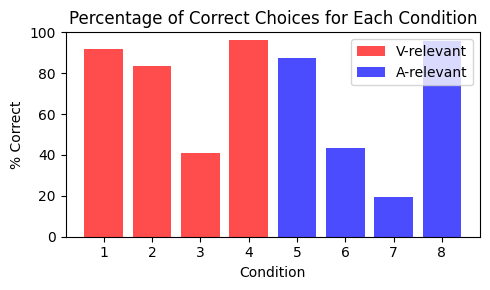

In [20]:
dataCell_list = convert_dataCell_to_dict(mat_data)
correct_values, condition_values, total_counts, correct_counts, percentage_correct, sorted_conditions, sorted_percentages = get_perc_correct_all_conditions(dataCell_list)
plot_perc_correct_all_conditions(sorted_conditions, sorted_percentages)

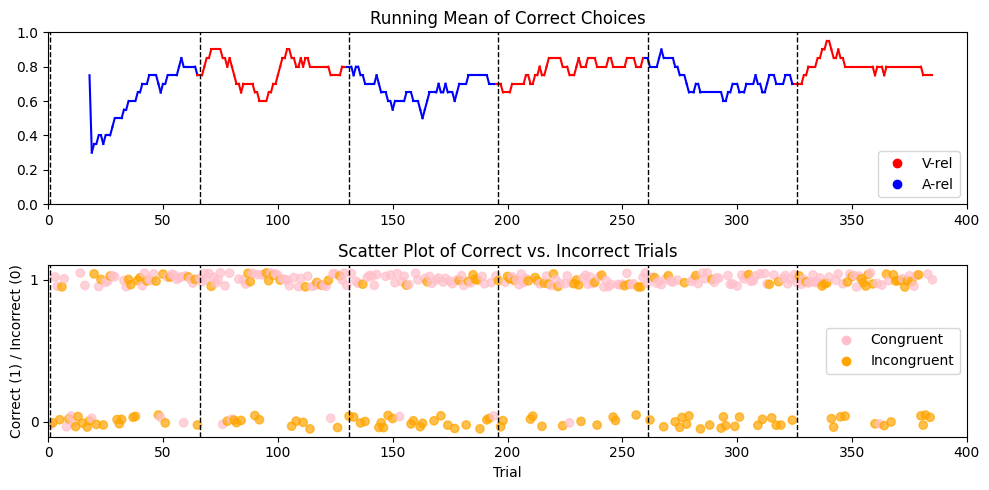

In [21]:
plot_performance(condition_values, correct_values)